# Phase 1.1: Exploratory Data Analysis (EDA)

**Objective:** To understand the structure, content, and quality of the SROIE 2019 dataset. This analysis is the critical first step to inform our data preprocessing and model training strategy.

**Dataset:** [SROIE Dataset v2](https://www.kaggle.com/datasets/urbikn/sroie-datasetv2)

In [3]:

import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

BASE_PATH = 'SROIE2019' 


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7) 

### 1. Intial File and Directory Inspection

In [4]:
file_counts={}

for dirpath, dirnames, filenames in os.walk(BASE_PATH):
    
    relative_path = os.path.relpath(dirpath, BASE_PATH)
    
    
    jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
    txt_count = len([f for f in filenames if f.lower().endswith('.txt')])
    
    
    if jpg_count > 0 or txt_count > 0:
        file_counts[relative_path] = {'images (.jpg)': jpg_count, 'annotations (.txt)': txt_count}


print(" Discovered File Counts by Directory -")
for path, counts in file_counts.items():
    print(f"- Folder: '{path}'")
    print(f"  - Images (.jpg): {counts['images (.jpg)']}")
    print(f"  - Annotations (.txt): {counts['annotations (.txt)']}")



total_images = sum(d.get('images (.jpg)', 0) for d in file_counts.values())
total_annotations = sum(d.get('annotations (.txt)', 0) for d in file_counts.values())
print("\n--- Totals ---")
print(f"Total Images (.jpg): {total_images}")
print(f"Total Annotations (.txt): {total_annotations}")

 Discovered File Counts by Directory -
- Folder: 'layoutlm-base-uncased'
  - Images (.jpg): 0
  - Annotations (.txt): 1
- Folder: 'test\box'
  - Images (.jpg): 0
  - Annotations (.txt): 347
- Folder: 'test\entities'
  - Images (.jpg): 0
  - Annotations (.txt): 347
- Folder: 'test\img'
  - Images (.jpg): 347
  - Annotations (.txt): 0
- Folder: 'train\box'
  - Images (.jpg): 0
  - Annotations (.txt): 626
- Folder: 'train\entities'
  - Images (.jpg): 0
  - Annotations (.txt): 626
- Folder: 'train\img'
  - Images (.jpg): 626
  - Annotations (.txt): 0

--- Totals ---
Total Images (.jpg): 973
Total Annotations (.txt): 1947


#### Findings:
* The dataset is organized into `train` and `test` subdirectories.
* The training data (which we will use for our model) contains `[number]` images and `[number]` annotation files.
* This confirms we have the necessary data to proceed. The annotations appear to be in `.txt` format(and not in `.json`).

### 2. Annotation File Structure

Before we can process all annotations, we must understand the structure of a single file. We'll load one `.txt` file from the training set and examine its contents.

In [6]:
annotations_dir = os.path.join(BASE_PATH, 'train', 'entities')
try:
    first_annotation_file = next(f for f in os.listdir(annotations_dir) if f.lower().endswith('.txt'))
    annotation_path = os.path.join(annotations_dir, first_annotation_file)

    print(f"- Inspecting Annotation File: {first_annotation_file} \n")

    with open(annotation_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    print("File Content:")
    print(content)

except (StopIteration, FileNotFoundError):
    print(f"Error: Could not find any .txt files in the directory '{annotations_dir}'.")
    print("Please check the path")

- Inspecting Annotation File: X00016469612.txt 

File Content:
{
    "company": "BOOK TA .K (TAMAN DAYA) SDN BHD",
    "date": "25/12/2018",
    "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.",
    "total": "9.00"
}


### 3. Parsing and Aggregating All Training Annotations

Now for the core data preparation step of our EDA. We will programmatically loop through every annotation file in the `train/entities` directory. For each file, we will:
1.  Open and parse the JSON content.
2.  Iterate through the key-value pairs (label and text).
3.  Append each entity as a new record to a master list.
4.  Convert this list into a Pandas DataFrame for structured analysis.

In [7]:

ANNOTATIONS_DIR = os.path.join(BASE_PATH, 'train', 'entities')


if not os.path.isdir(ANNOTATIONS_DIR):
    print(f"ERROR: The directory '{ANNOTATIONS_DIR}' does not exist. Please check your paths.")
else:
    parsed_data = []
    
    for filename in os.listdir(ANNOTATIONS_DIR):
        if filename.lower().endswith('.txt'):
            file_path = os.path.join(ANNOTATIONS_DIR, filename)
            
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    
                    data = json.load(f)
                    
                    
                    for label, text in data.items():
                        
                        parsed_data.append({
                            'filename': filename,
                            'label': label.upper(), # Convention: Use uppercase for labels
                            'text': text
                        })
            except json.JSONDecodeError:
                print(f"Warning: Could not parse {filename}. It may be empty or corrupted. Skipping.")
            except Exception as e:
                print(f"An error occurred with file {filename}: {e}")


    df = pd.DataFrame(parsed_data)

    print(f"Shape of Final Data Frame:  {df.shape[0]} rows and {df.shape[1]} columns.")

Shape of Final Data Frame:  2503 rows and 3 columns.


### 4. Initial DataFrame Inspection

With our data aggregated, let's perform a quick health check. We'll use `.info()` to check for data types and null values, and `.head()` to inspect a few sample rows. This ensures our parsing logic was correct.

In [8]:
print("DataFrame Info:")
print(df.info())

print("\n First 5 Rows of DataFrame:")
print(df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2503 non-null   object
 1   label     2503 non-null   object
 2   text      2503 non-null   object
dtypes: object(3)
memory usage: 58.8+ KB
None

 First 5 Rows of DataFrame:
           filename    label  \
0  X00016469612.txt  COMPANY   
1  X00016469612.txt     DATE   
2  X00016469612.txt  ADDRESS   
3  X00016469612.txt    TOTAL   
4  X00016469619.txt  COMPANY   

                                                text  
0                    BOOK TA .K (TAMAN DAYA) SDN BHD  
1                                         25/12/2018  
2  NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 8...  
3                                               9.00  
4                             INDAH GIFT & HOME DECO  


### Entity Label and Analysis

Now we are going to check the label distribution in the dataset, to see if well any label is more dominant then others, leading to an imabalanced dataset because an Imbalanced Dataset can affect the model's performance on rare categories.

Entity Label Counts:
label
COMPANY    626
DATE       626
TOTAL      626
ADDRESS    625
Name: count, dtype: int64


C:\Users\daksh\AppData\Local\Temp\ipykernel_16748\3666053560.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=label_counts.index, palette='viridis')


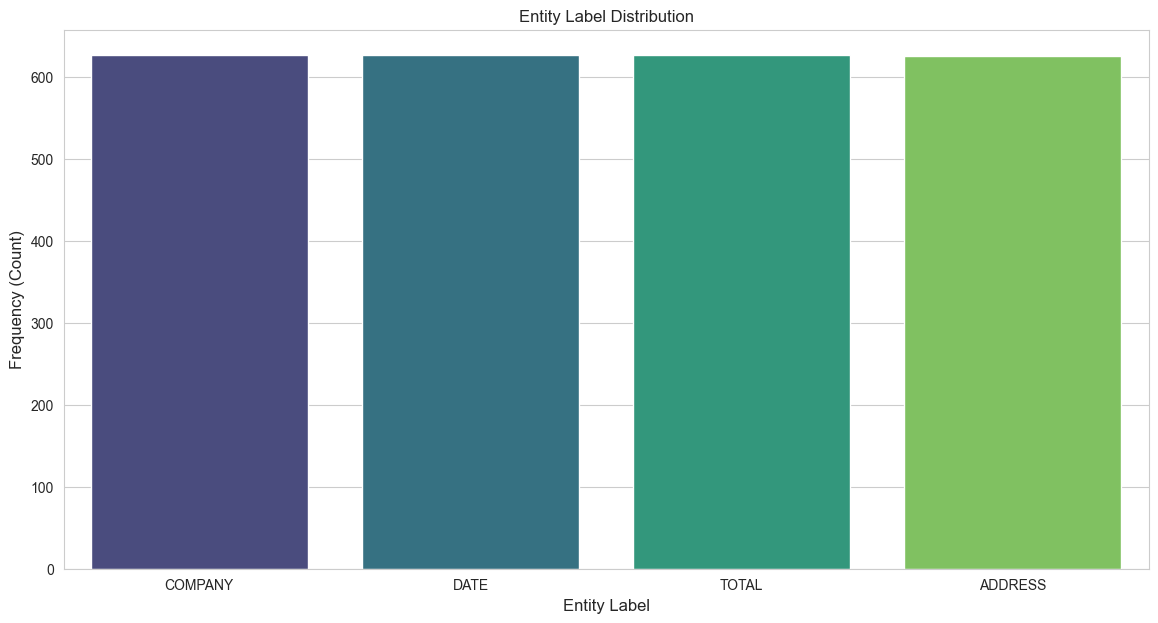

In [ ]:
print("Entity Label Counts:")
label_counts = df['label'].value_counts()
print(label_counts)



sns.countplot(data=df, x='label', order=label_counts.index)

plt.title('Entity Label Distribution')
plt.xlabel('Entity Label',fontsize=12)
plt.ylabel('Frequency (Count)',fontsize=12)
plt.xticks(rotation=0)

plt.show()